In [1]:
####################################################################################################
#################################__#########################################_ ######################               
###############################/ _|########################################| |######################               
#######  ___ _   _  ___  ___  | |##########################################| |_ ___ _ __ ___ #######
####### / _ \ | | |/ _ \/ __| |  _/ _ \| '__/ __/ _ \| '_ ` _ \| '_ \| | | | __/ _ \ '__/ __|#######
### ###|  __/ |_| |  __/\__ \_| || (_) | |_| (_| (_) | | | | | | |_) | |_| | ||  __/ |  \__ \#######
###### \___|\__, |\___||___(_)_| \___/|_(_)\___\___/|_| |_| |_| .__/ \__,_|\__\___|_|  |___/#######
#############__/ |############################################| |###################################                           
############|___/ ############################################|_|###################################                           
####################################################################################################
#
# Purpose: Detect anomalies between a particular staff/client in a dataset of more extreme behaviors
#
#          Questions answered: 
#
#          Does any client exhibit more of any particulr behavior with a specific staff?
#          Does any staff member observe more of any particulr behavior across their clients?
#          
#          
#                             
#
# This notebook completes the Staff/Client behavior interaction anomaly detection project
# After loading the data, adding in support for the categorical variables, standardizing the data,
# subsetting on the outliers, producing a heatmap and exploratory plots, a DBSCAN model was generated
# to find extreme values. Iteration was used to find the optimal value for parameters. The manual 
# process identified about twice as many outliers as the DBSCAN model. The manual model is more flexible
# and allows more domain knowledge control. Future work would start with the manual model.
# 
# Future work: Extend detection to include skill program targets in addition to behaviors.
#              Collect information on gender, observation location and time of session.
#              Define more relationships between independent variables.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [3]:
df = pd.read_excel('bx_appointments.xlsx', index_col='Client')
print(df.dtypes)
print(df.shape)

Date              datetime64[ns]
Day                        int64
Staff Member              object
Duration                 float64
aggression                 int64
elope                      int64
non-compliance           float64
protesting               float64
sib                      float64
dtype: object
(1000, 9)


In [4]:
df.Day = df.Day.astype('category')
df['client'] = df.index

df['Staff Member'] = df['Staff Member'].astype('category')
df['client'] = df['client'].astype('category')

In [5]:
dummies = pd.get_dummies(df['Staff Member'],df.client,df.Day, sparse=True)

In [6]:
dummies.shape

(1000, 39)

In [7]:
df = df.merge(dummies, left_index=True, right_index=True)
print(df.shape)

(137392, 49)


In [8]:
bx_list = ['aggression', 'elope', 'non-compliance', 'protesting', 'sib']


scaler = StandardScaler()

# Fitting data to the scaler object

scaled_df = scaler.fit_transform(df[bx_list])
scaled_df = pd.DataFrame(scaled_df, columns=bx_list)
scaled_df.head(3)

,aggression,elope,non-compliance,protesting,sib
0,-0.399086,-0.460239,-0.094702,-0.570422,2.000233
1,-0.399086,-0.460239,-0.094702,-0.570422,2.000233
2,-0.399086,-0.460239,-0.094702,-0.570422,2.000233


In [9]:
merged = df
for i in scaled_df.columns:
    merged[i] = scaled_df[i].values
    
merged_db = merged

In [10]:
##############################################################################################
# Purpose: Create a df of observations where client showed their max instance of each bx     #
#          This is a dataset of the most extreme observations for each column and how they   #
#          relate to other bx in the same session                                            #
#                                                                                            #
#                                                                                            #
# Returns df of all clients where the observation with the instance of max bx_list           #
# The max frame is all of the category data as well as standarized bx                        #
#                                                                                            #
# Takes in a standarized df of client observations with dummies                              #
##############################################################################################
bx_list = ['aggression', 'elope', 'non-compliance', 'protesting', 'sib']


def extreme_df(df):
    
    clients = df.index.unique()
    clients_max = pd.DataFrame()
    full_frame = pd.DataFrame()

    for i in clients:
    
        clients_frame = df.loc[df.client == i]
#    clients_frame = clients_frame[bx_list]
    
        for bx in bx_list:
    
            clients_max = clients_max.append(clients_frame[clients_frame[bx] == clients_frame[bx].max()].drop_duplicates())
#        full_frame = clients_max.append(clients_frame[clients_frame[bx] == clients_frame[bx]]) #max?

    print('done')
    return clients_max
    
clients_max = extreme_df(df)
    

done


In [11]:

clients_max.to_csv('clients_max.csv')
cols_to_keep = ['Date', 'Day', 'Staff Member', 'Duration', 'aggression', 'elope', 'non-compliance', 'protesting', 'sib', 'client']


In [12]:
##########################################################################################################
# Purpose: Identify clients' that have had instances of bx more than 2 std from their mean.              #
#          Highlights what behaviors can be more extreme for a particular client.                        #
#                                                                                                        #
# If any clients bx is outside 2.5 std deviation of their mean, then we want that pointed out            #
# Later: grab the full session row to use elsewhere                                                      #
##########################################################################################################
def flag_it(df):
    
    cols_to_keep = ['Problem','Date', 'Day', 'Staff Member', 'Duration', 'aggression', 'elope', 'non-compliance', 'protesting', 'sib', 'client']
    bx_list = ['aggression', 'elope', 'sib', 'non-compliance', 'protesting']
    extreme_obs = pd.DataFrame(columns=cols_to_keep)
    flags = pd.DataFrame(columns=['client', 'bx', 'mean','thresh'])
    extreme = []
    
    for c in df.client.unique():
        
        
        for bx in bx_list:
            
            bx_df = df.loc[df['client'] == c]
            client_bx_df = bx_df[bx]

            
            mean = client_bx_df.mean()
            std = client_bx_df.std()
            thresh = mean + std*2.5
                        
            extreme_obs = extreme_obs.append(bx_df.loc[bx_df[bx] > thresh])
            


            if client_bx_df.any() > thresh:
                flags = flags.append({'client' : c, 'bx' : bx, 'mean' : mean, 'thresh' : thresh}, ignore_index=True)

    
    extreme_obs = extreme_obs[cols_to_keep].drop_duplicates()
    

    return flags, extreme_obs
    
flags, extreme_obs = flag_it(df)
print('Original df size: ' + str(len(df.drop_duplicates())))
print('extreme_obs size: ' + str(len(extreme_obs.drop_duplicates())))
extreme_obs.reset_index()

Original df size: 9840
extreme_obs size: 95


,index,Problem,Date,Day,Staff Member,Duration,aggression,elope,non-compliance,protesting,sib,client
0,client_0,NaN,2021-07-12,0,staff_23,6.00,0.722242,-0.460239,0.172368,-0.339360,2.797564,client_0
1,client_0,NaN,2021-06-29,1,staff_31,3.00,0.722242,0.185379,-0.295005,-0.570422,-0.125984,client_0
2,client_0,NaN,2021-06-29,1,staff_33,4.00,0.722242,0.185379,-0.295005,-0.570422,-0.125984,client_0
3,client_0,NaN,2021-05-28,4,staff_8,7.00,1.282906,-0.460239,-0.495307,-0.570422,0.405570,client_0
4,client_0,NaN,2021-05-14,4,staff_41,6.00,1.096018,-0.137430,-0.361772,-0.570422,0.937124,client_0
...,...,...,...,...,...,...,...,...,...,...,...,...
90,client_8,NaN,2021-03-08,0,staff_2,3.50,2.217347,0.185379,NaN,NaN,NaN,client_8
91,client_8,NaN,2021-05-12,2,staff_25,3.00,-0.399086,0.508188,NaN,NaN,NaN,client_8
92,client_8,NaN,2021-05-12,2,staff_2,4.75,-0.399086,0.508188,NaN,NaN,NaN,client_8
93,client_8,NaN,2021-04-16,4,staff_2,2.50,-0.585974,0.830997,NaN,NaN,NaN,client_8


In [13]:
extreme_obs[bx_list].describe()

,aggression,elope,non-compliance,protesting,sib
count,95.000000,95.000000,65.000000,36.000000,60.000000
mean,0.606175,1.075652,0.122035,0.416405,1.610426
std,1.688646,2.219427,0.705420,1.569532,2.263918
min,-0.585974,-0.460239,-0.495307,-0.570422,-0.391761
25%,-0.585974,-0.298834,-0.361772,-0.483774,-0.391761
50%,-0.212198,0.185379,-0.094702,-0.281595,0.937124
75%,1.096018,0.830997,0.439438,0.180529,2.531787
max,5.020668,8.578412,2.442462,4.224113,9.176212


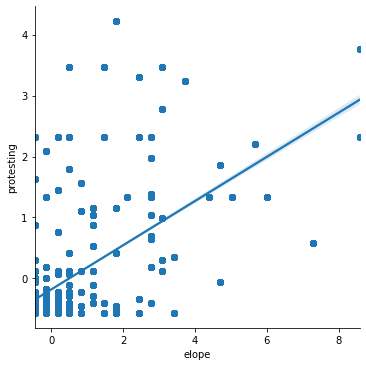

In [14]:
sns.lmplot(x='elope',y='protesting',data=merged_db,fit_reg=True) 

In [15]:
#####################################################################
# Purpose: Get the threshold value of a bahavior for any one client #
#####################################################################

def get_thresh(client,bx):
    
    c = flags['client'] == client
    b = flags['bx'] == bx
    thresh = flags[c&b]['thresh']
    thresh = thresh
    
    return thresh

In [16]:
#############################################################################################
# Purpose: Create a bool series for threshold for each observation if it was the extreme bx #
#############################################################################################

output = []
for i, row in extreme_obs.iterrows():
  obs_behavior = {}
  for indicator in bx_list:
    thresh = get_thresh(row['client'], indicator)
    if len(thresh) > 0:
        obs_thres_higher = row[indicator] > thresh.iloc[0]
    else:
        obs_thres_higher = None
    obs_behavior[indicator] = obs_thres_higher
  output.append(obs_behavior)

In [17]:
###############################################################################################################
# Purpose: Return named bx for each row in output that exceeds the threshold. Then adds them to extreme_obs df#
###############################################################################################################

bxdict = []

def get_key(bxdict,val):
    for key, value in bxdict.items():
         if val == value:
             return key
 
    return "na"

for i,d in enumerate(output):
    
    bx = get_key(output[i],True)
    bxdict.append(bx)
    
extreme_obs['Problem'] = bxdict
extreme_obs.sample(5)

,Problem,Date,Day,Staff Member,Duration,aggression,elope,non-compliance,protesting,sib,client
client_7,na,2021-05-05,2,staff_3,2.75,5.020668,-0.460239,NaN,NaN,-0.391761,client_7
client_1,na,2021-06-10,3,staff_47,3.00,3.899339,1.799424,NaN,4.224113,NaN,client_1
client_3,aggression,2021-03-24,2,staff_21,4.00,0.161578,0.185379,-0.295005,NaN,1.468679,client_3
client_8,aggression,2021-03-08,0,staff_2,3.50,2.217347,0.185379,NaN,NaN,NaN,client_8
client_1,na,2021-06-07,0,staff_24,3.00,-0.585974,8.578412,NaN,3.761989,NaN,client_1


In [18]:
flags.sample(3)

,client,bx,mean,thresh
8,client_4,aggression,-0.514094,-0.163318
5,client_3,aggression,-0.561384,-0.306105
10,client_4,non-compliance,-0.364982,0.142377


<AxesSubplot:>

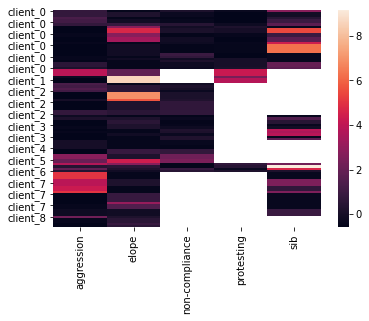

In [19]:
sns.heatmap(extreme_obs[bx_list])

<AxesSubplot:>

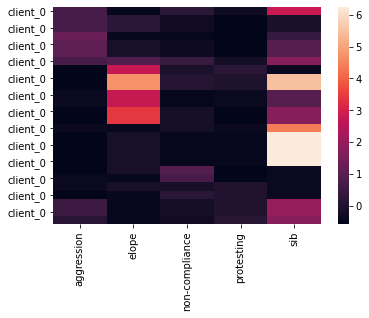

In [20]:
# heatmap for single client

c0 = extreme_obs['client'] == 'client_0'
extreme_obs[c0]
sns.heatmap(extreme_obs[c0][bx_list])


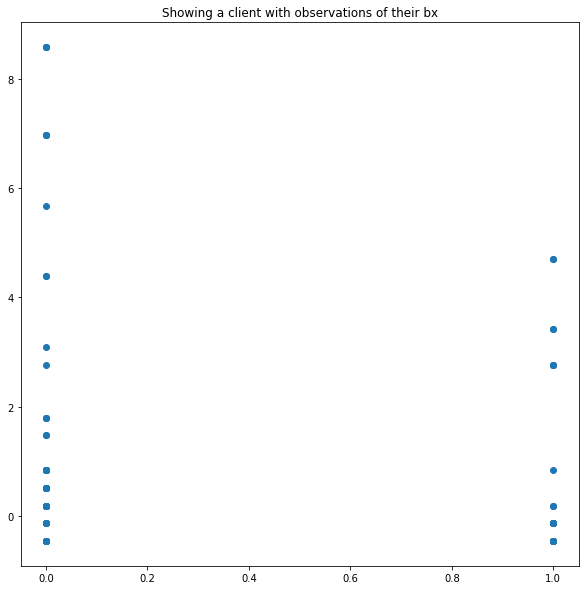

In [21]:
# Can plot client/staff by bx

plt.rcParams['figure.figsize'] = [10, 10]

a = extreme_obs['client'] == 'client_0'
plt.title('Showing a client with observations of their bx')

plt.scatter(a,extreme_obs['elope'] )


In [22]:
#####################################################################
# Purpose: Produce list of how many extreme observations per client #
#####################################################################


client_extreme = pd.DataFrame(columns=['client','entries']) # add bx col

for c in extreme_obs.client.unique():#extreme_obs.index.unique():
    
    aa = pd.DataFrame(extreme_obs.loc[extreme_obs.client == c])
    l = len(extreme_obs.loc[extreme_obs.client == c])
    
   
    client_extreme = client_extreme.append({'client' : c, 'entries' : l}, ignore_index=True).sort_values(by='entries', ascending=False)
    
client_extreme

,client,entries
0,client_0,26
1,client_7,19
2,client_2,14
3,client_3,11
4,client_1,6
5,client_4,6
8,client_8,5
6,client_5,4
7,client_6,4


In [23]:
#####################################################################
# Purpose: Produce list of how many extreme observations by staff   #
#####################################################################

staff_extreme = pd.DataFrame(columns=['staff','entries']) 

for c in extreme_obs['Staff Member'].unique():
    
    aa = pd.DataFrame(extreme_obs.loc[extreme_obs['Staff Member'] == c])
    l = len(extreme_obs.loc[extreme_obs['Staff Member'] == c])
    
   
    staff_extreme = staff_extreme.append({'staff' : c, 'entries' : l}, ignore_index=True).sort_values(by='entries', ascending=False)
    
    staff_extreme = staff_extreme[staff_extreme['entries']  > 4]
    
staff_extreme

,staff,entries
0,staff_11,10
1,staff_8,9
2,staff_21,9
3,staff_31,7
4,staff_41,7
5,staff_33,5
6,staff_17,5
7,staff_14,5
8,staff_13,5


In [24]:
len(extreme_obs)

95

In [25]:
###############################################################################################
# Purpose: Find the best epsilon value for a dbscan model on our data                         #
#                                                                                             #
# Output several plots for values of eps                                                      #
###############################################################################################
from sklearn.cluster import DBSCAN

'''

data = merged_db[bx_list].fillna(0)
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
rlist = [1,1.5,2,2.5,3,3.5,4]

for x in rlist:#range(10, 0, -1):
    eps = x
#    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=20).fit(data)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    print(eps)
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
    sns.scatterplot(data.iloc[:,0], data.iloc[:,1], hue=["cluster-{}".format(x) for x in labels])
    i += 1

'''


'\n\ndata = merged_db[bx_list].fillna(0)\nfig = plt.figure(figsize=(20,10))\nfig.subplots_adjust(hspace=.5, wspace=.2)\ni = 1\nrlist = [1,1.5,2,2.5,3,3.5,4]\n\nfor x in rlist:#range(10, 0, -1):\n    eps = x\n#    eps = 1/(11-x)\n    db = DBSCAN(eps=eps, min_samples=20).fit(data)\n    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)\n    core_samples_mask[db.core_sample_indices_] = True\n    labels = db.labels_\n    \n    print(eps)\n    ax = fig.add_subplot(2, 5, i)\n    ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")\n    sns.scatterplot(data.iloc[:,0], data.iloc[:,1], hue=["cluster-{}".format(x) for x in labels])\n    i += 1\n\n'

/home/eyesforcomputers/anaconda3/envs/data_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


outliers: 15
input length: 405
Estimated number of clusters: 1
Estimated number of noise points: 15
Items found from kmeans and extreme_obs: 4
Silhouette Score: 0.599


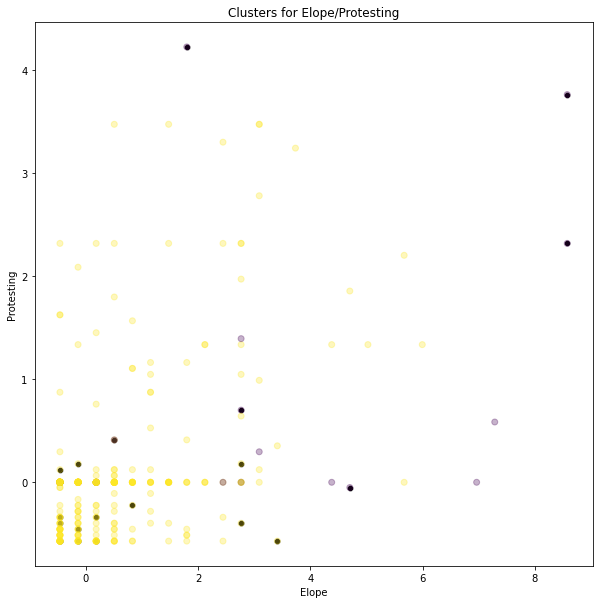

In [26]:
###############################################################################################
# Purpose: Determine clusters within the full behavor datafame within to identify as anomalias#
#          using dbscan. Calculate the silhouette scores and compare the findings to          #
#          extreme_obs df                                                                     #
#                                                                                             #
# Generates details on dbscan clustering and compares the model to the extreme_obs df         #
# Also, outputs example clustered df for elope/protesting                                     #
###############################################################################################



from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics

merged_db = merged.drop_duplicates()
data = merged_db[bx_list].fillna(0).drop_duplicates()

model = DBSCAN(eps = 2.5, min_samples = 20).fit(data)
labels = model.labels_

colors = model.labels_
plt.xlabel('Elope')
plt.ylabel('Protesting')
plt.title('Clusters for Elope/Protesting')


# Data from the manual extreme df
sns.scatterplot(extreme_obs.elope,extreme_obs.protesting, color='black')#, marker='x')

plt.scatter(data["elope"], data['protesting'], c = colors, alpha=.3)



outliers = data[model.labels_ == -1]

print('outliers: ' + str(len(outliers)))
print('input length: ' + str(len(data)))

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

in_both = extreme_obs.merge(outliers, how = 'inner' ,indicator=False).drop_duplicates()
#in_both = in_both.drop_duplicates()
print('Items found from kmeans and extreme_obs: ' + str(len(in_both)))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(data, labels))

plt.show()

In [69]:
outliers[:]

,aggression,elope,non-compliance,protesting,sib,outliersTrue
Client,,,,,,
client_0,-0.585974,4.704705,0.105600,-0.050533,5.455334,True
client_1,-0.212198,8.578412,0.000000,2.317852,0.000000,True
client_1,3.899339,1.799424,0.000000,4.224113,0.000000,True
client_1,-0.585974,8.578412,0.000000,3.761989,0.000000,True
client_1,-0.585974,7.287176,0.000000,0.584888,0.000000,True
client_2,-0.585974,6.964367,0.105600,0.000000,0.000000,True
client_5,2.217347,2.445042,4.378720,0.000000,0.000000,True
client_5,2.030459,4.381896,2.442462,0.000000,0.000000,True
client_5,1.656682,2.767851,5.380232,0.000000,0.000000,True


In [27]:
#outliers = data[model.labels_ == -1]#.drop_duplicates()

outliers = outliers.drop_duplicates()
print(len(outliers), outliers.head(3))
print('\nNumber DBSCAN found True: ',len(in_both))




15           aggression     elope  non-compliance  protesting       sib
Client                                                              
client_0   -0.585974  4.704705          0.1056   -0.050533  5.455334
client_1   -0.212198  8.578412          0.0000    2.317852  0.000000
client_1    3.899339  1.799424          0.0000    4.224113  0.000000

Number DBSCAN found True:  4


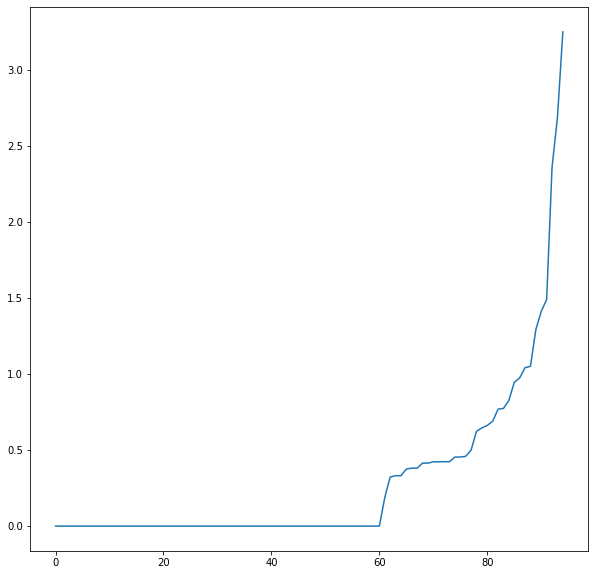

In [28]:
from sklearn.neighbors import NearestNeighbors

eo = extreme_obs.fillna(extreme_obs[bx_list].mean())

data = eo[bx_list]

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(data)
distances, indices = neighbors_fit.kneighbors(data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [29]:
#data = merged_db[bx_list].fillna(merged_db[bx_list].mean())


/home/eyesforcomputers/anaconda3/envs/data_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/eyesforcomputers/anaconda3/envs/data_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


input length: 405
Estimated number of clusters: 2
Estimated number of noise points: 56
Same found in each frame: 8
Silhouette Score(n=2): 0.4833183058406453


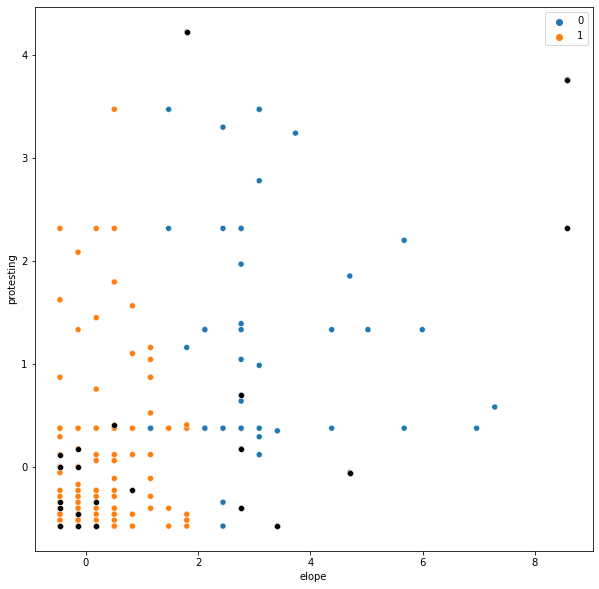

In [30]:
###############################################################################################
# Purpose: Examine clusters produced by kmeans model. Two clustrs were chosen to seperate     #
#          extreme from non-extreme observations                                              #
#                                                                                             #
# Generates details on kmeans clustering and compares the model to the extreme_obs df         #
# Also, outputs example plot for clustered df elope/protesting                                #
###############################################################################################

from sklearn.cluster import KMeans

kmdata = []
kmlabels = []

kmdata = merged_db[bx_list].fillna(merged_db[bx_list].mean())
kmdata = kmdata.drop_duplicates()

km = KMeans(2)
km.fit(kmdata)
kmlabels=km.predict(kmdata)

# Find the extreme outliers
kmoutliers = kmdata[km.labels_ == 0]


sns.scatterplot(kmdata.elope,kmdata.protesting,hue=kmlabels, color='blue')

# Data from the manual extreme df
sns.scatterplot(extreme_obs.elope,extreme_obs.protesting, color='black')



print('input length: ' + str(len(kmdata)))
n_clusters_ = len(set(kmlabels)) - (1 if -1 in kmlabels else 0)
n_noise_ = len(kmoutliers)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

in_both = extreme_obs.merge(kmoutliers, how = 'inner' ,indicator=False)
print('Same found in each frame: ' + str(len(in_both)))
print(f'Silhouette Score(n=2): {silhouette_score(kmdata.drop_duplicates(), kmlabels)}')


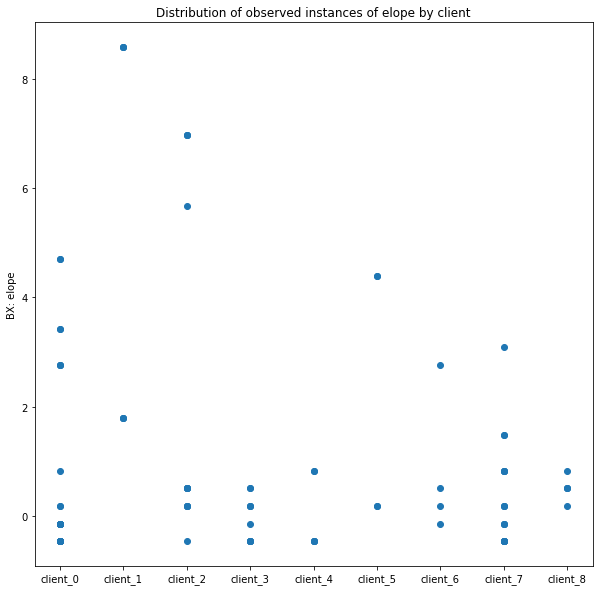

In [31]:
client_elope = plt.scatter(extreme_obs['client'],extreme_obs['elope'])
plt.title('Distribution of observed instances of elope by client')
plt.ylabel('BX: elope')
plt.show()

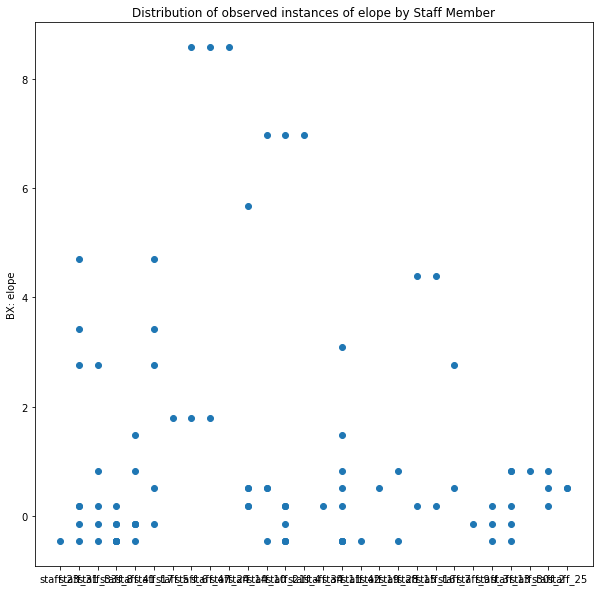

In [32]:
client_elope = plt.scatter(extreme_obs['Staff Member'],extreme_obs['elope'])

#client_elope = client_elope['elope'] > .4
plt.title('Distribution of observed instances of elope by Staff Member')
plt.ylabel('BX: elope')
plt.show()